---
title: NRT Fire and FWI Visualizations


description: Use a FireID/Name to create quick plots of the active fire, it's growth over time, a gif, and when available the weather surrounding the fire's origin.


author: Avery Fratto
date: July 1, 2024


## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/mccabete/fwiVis.git/NRT_notebook?labpath=NRT_notebook.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

Let's start by importing some of the necessary packages

In [4]:
!pip install OWSLib==0.28.1 --quiet
!pip3 install contextily
!pip install geodatasets
!pip install matplotlib-scalebar
!pip install imageio
!pip install imageio[ffmpeg]
!pip install imageio[pyav]
!pip install imageio==2.27.0

  Using cached contextily-1.6.0-py3-none-any.whl.metadata (2.9 kB)
Using cached contextily-1.6.0-py3-none-any.whl (17 kB)
  Using cached geodatasets-2024.7.0-py3-none-any.whl.metadata (5.4 kB)
Using cached geodatasets-2024.7.0-py3-none-any.whl (19 kB)
  Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl.metadata (13 kB)
Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl (17 kB)


In [191]:
from owslib.ogcapi.features import Features
import geopandas as gpd
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
%matplotlib inline
import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
from geodatasets import get_path
import matplotlib.patches as mpatches 
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib 
import cartopy.crs as ccrs
from matplotlib.pyplot import legend
import imageio.v2 as imageio
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
import sys
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from bs4 import BeautifulSoup
import requests
sys.path.insert(0, '/projects/fwiVis/base-fwi-vis/fwiVis')
import fwiVis as fv
from shapely.geometry.point import Point
import importlib
importlib.reload(fv)
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

## About the Data


The fire data shown is generated by the FEDs algorithm. The FEDs algorithm tracks fire movement and severity by ingesting observations from the VIIRS thermal sensors on the Suomi NPP and NOAA-20 satellites. This algorithm uses raw VIIRS observations to generate a polygon of the fire, locations of the active fire line, and estimates of fire mean Fire Radiative Power (FRP). The VIIRS sensors overpass at ~1:30 AM and PM local time, and provide estimates of fire evolution ~ every 12 hours. The data produced by this algorithm describe where fires are in space and how fires evolve through time. This CONUS-wide implementation of the FEDs algorithm is based on [Chen et al 2020’s](https://www.nature.com/articles/s41597-022-01343-0) algorithm for California.


The data produced by this algorithm is considered experimental. 

We'll now set up the API for queries and create some easy to access datetime variables. 

In [192]:
OGC_URL = "https://firenrt.delta-backend.com"

w = Features(url=OGC_URL)

We will focus on the `public.eis_fire_snapshot_fireline_nrt` collection, the `public.eis_fire_snapshot_perimeter_nrt` collection, and the `public.eis_fire_lf_perimeter_archive` collection here. 

In [193]:
perm = w.collection("public.eis_fire_snapshot_perimeter_nrt")

In [194]:
perm_q = w.collection_queryables("public.eis_fire_snapshot_perimeter_nrt")

Now that we've read in the API, we're going to focus on fires in the past week or month (depending on user needs). 

In [195]:
## Get the most recent fire perimeters, and 7 days before most recent fire perimeter
most_recent_time = max(*perm["extent"]["temporal"]["interval"])
now = dt.datetime.strptime(most_recent_time, "%Y-%m-%dT%H:%M:%S+00:00")
last_week = now - dt.timedelta(weeks=1)
last_week = dt.datetime.strftime(last_week, "%Y-%m-%dT%H:%M:%S+00:00")
last_month = now - dt.timedelta(days=50)
last_month = dt.datetime.strftime(last_month, "%Y-%m-%dT%H:%M:%S+00:00")
print("Most Recent Time =", most_recent_time)
print("Last week =", last_week)
print("Last month =", last_month)
two_months= now - dt.timedelta(days=75)
two_months = dt.datetime.strftime(two_months, "%Y-%m-%dT%H:%M:%S+00:00")
print("Two months =", two_months)

Most Recent Time = 2024-07-23T00:00:00+00:00
Last week = 2024-07-16T00:00:00+00:00
Last month = 2024-06-03T00:00:00+00:00
Two months = 2024-05-09T00:00:00+00:00


With that done, we can get to mapping fires!

## If you have the fire by name, we can search for it that way.

In [211]:
NameOfFire='little twist'

To start, we will search for the input. This cell queries a geodataframe from the National Interagency Fire Center. It contains all current fires' perimeters as a polygon layer. These features contains the names. By exeucting a spatial join with the snapshort_perimieter_nrt, we can join any names to fires that geogrpahically overlap. Then, we can see if the inputted name is joined with any fire in the veda layer. 

In [212]:
if NameOfFire:
    perurl = 'https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters_Current/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
    polygdf = gpd.read_file(perurl)
    polygdf = polygdf.set_crs("EPSG:4326")
    polygdf['poly_IncidentName'] = polygdf['poly_IncidentName'].str.lower()
    #buffering WFIGS polygon layer by 187.5m, the "radius" of the spatial resolution of VIIRS
    polygdf = polygdf.to_crs(epsg=32633)
    polygdf['geometry'] = polygdf['geometry'].buffer(187.5)
    
    perm_results = w.collection_items(
    "public.eis_fire_snapshot_perimeter_nrt",  # name of the dataset we want
    bbox=('-125', '-65', '24', '50'),  # coordinates of bounding box
    datetime=[two_months + "/" + most_recent_time],  # date range
    limit=9999,  # max number of items returned
    )

    mydf = gpd.GeoDataFrame.from_features(perm_results["features"])
    mydf = mydf.set_crs("EPSG:4326")
    mydf = mydf.to_crs(epsg=32633)
    mydf = mydf[mydf['farea'] >= 5]
    
    poly_join_inner_df = mydf.sjoin(polygdf, how="inner")
    
    NameOfFire = NameOfFire.lower()
    
    if NameOfFire in poly_join_inner_df['poly_IncidentName'].values:
        fireid = poly_join_inner_df[poly_join_inner_df['poly_IncidentName'] == NameOfFire]
        userPlace = fireid['fireid'].values[0]
        print("fireid associated with", NameOfFire,  "fire is", userPlace)
        
        activePerm_results = w.collection_items(
        "public.eis_fire_snapshot_fireline_nrt",  # name of the dataset we want
        filter= f'fireid = {userPlace}',
        limit=9999
        )

        perm_results = w.collection_items(
        "public.eis_fire_snapshot_perimeter_nrt",  # name of the dataset we want
        filter= f'fireid = {userPlace}',
        limit=9999,  # max number of items returned
        )

        df = gpd.GeoDataFrame.from_features(perm_results["features"])
        df = df.set_crs("EPSG:4326")

        activePermdf= gpd.GeoDataFrame.from_features(activePerm_results["features"])
        activePermdf= activePermdf.set_crs("EPSG:4326")
        
        
    else: 
        print("The name is not present in the WFIGS dataset of current fire incidents, so we could not join a name to the fireid. Use the map below to find the fireid directly.")
    
    
    

fireid associated with little twist fire is 80464


Now, let's build a function to plot this fire.

In [213]:
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

In [214]:
def plot_snapshot(userPlace):
    place= df[df['fireid'] == userPlace]
    activePlace = activePermdf[activePermdf['fireid'] ==userPlace]

    fig = place.plot(figsize=(10,12), facecolor = 'None', edgecolor = 'orange', linewidth=3, legend = True)
    activePlace.plot( facecolor="none", ax=fig, edgecolor="red", linewidth=4, legend = True)
    time = str(place['t']).split('T')[0].split('  ')[2]
    plot_title =(f" {userPlace} Fire Perimeter and Active Fire Line on {time}")
    # capitalize Fire Name
    if NameOfFire:
        plot_title=(f" {NameOfFire} Fire Perimeter and Active Fire Line on {time}")
    fig.set_title(plot_title)
    fig.set_xlabel("Longitude")
    fig.set_ylabel("Latitude")                           
    fig.legend(['active fire line'])
    cx.add_basemap(fig, crs=place.crs.to_string(), source=cx.providers.Esri.WorldImagery, attribution = False)
    red_patch = mpatches.Patch(color='red', label = 'active fire line')
    orange_patch = mpatches.Patch(color = 'orange', label = 'perimeter')
    matplotlib.pyplot.legend(handles = [orange_patch,  red_patch], title='Legend', bbox_to_anchor=(1.0,1.0))
    scale1 = ScaleBar(
        dx=distance_meters,
        location="lower right",  # in relation to the whole plot
        box_alpha=0.8,
    )
    fig.add_artist(scale1)
    


Now run the function!

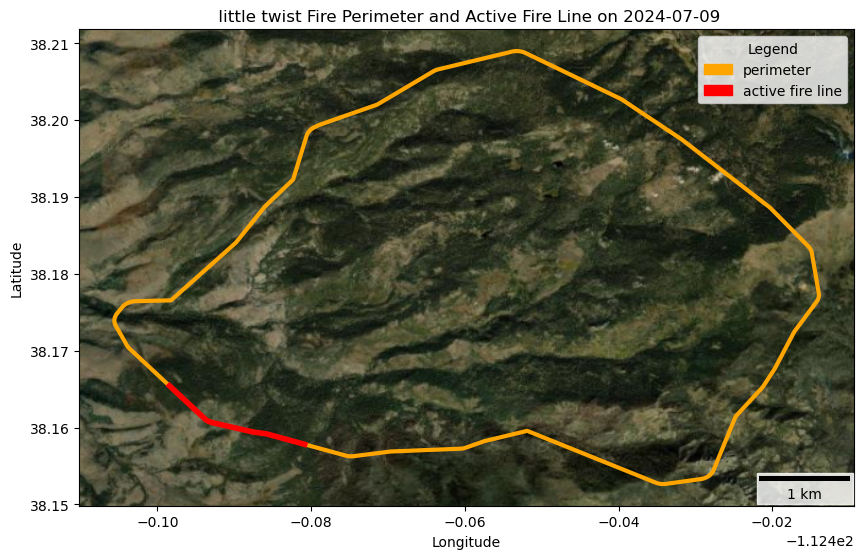

In [215]:
plot_snapshot(userPlace)

## If you're unsure of the name, if the fireid didn't match, or if you want to double check the ID provided, we can search for the fire by location.

In [216]:
state='Utah'

state = input("What State would you like the bounding box coordinates for?")

In [217]:
if state:
    bounding_boxes = pd.read_csv("US_State_Bounding_Boxes.csv")
    bounding_boxes = bounding_boxes[['NAME', 'xmin', 'ymin', 'xmax', 'ymax']]

    state_coordinates= bounding_boxes[bounding_boxes['NAME'] == state]
    state_coordinates = state_coordinates.values.tolist()
    state_coordinates = list(state_coordinates)
    state_coordinates = state_coordinates[0]
    state_coordinates = state_coordinates[1:5]


    new_state_coords = []
    for i in state_coordinates:
        i = f'{i}'
        new_state_coords.append(i)
    print(new_state_coords)

    activePerm_results = w.collection_items(
        "public.eis_fire_snapshot_fireline_nrt",  # name of the dataset we want
        bbox=new_state_coords,  # coodrinates of bounding box
        datetime=[two_months + "/" + most_recent_time],  # date range
        limit=9999
    )

    perm_results = w.collection_items(
        "public.eis_fire_snapshot_perimeter_nrt",  # name of the dataset we want
        bbox=new_state_coords,  # coordinates of bounding box
        datetime=[two_months + "/" + most_recent_time],  # date range
        limit=9999,  # max number of items returned
    )

    df = gpd.GeoDataFrame.from_features(perm_results["features"])
    df = df.set_crs("EPSG:4326")

    activePermdf= gpd.GeoDataFrame.from_features(activePerm_results["features"])
    activePermdf= activePermdf.set_crs("EPSG:4326")

df.explore()

['-114.052962', '36.997968', '-109.041058', '42.001567']


Use the map above to look at the fires in the state you selected. Zoom to where you know the fire happened, and select the fire to get its fireid. 

In [218]:
userPlace = 80464

Now let's use our previously built function to plot the fire.

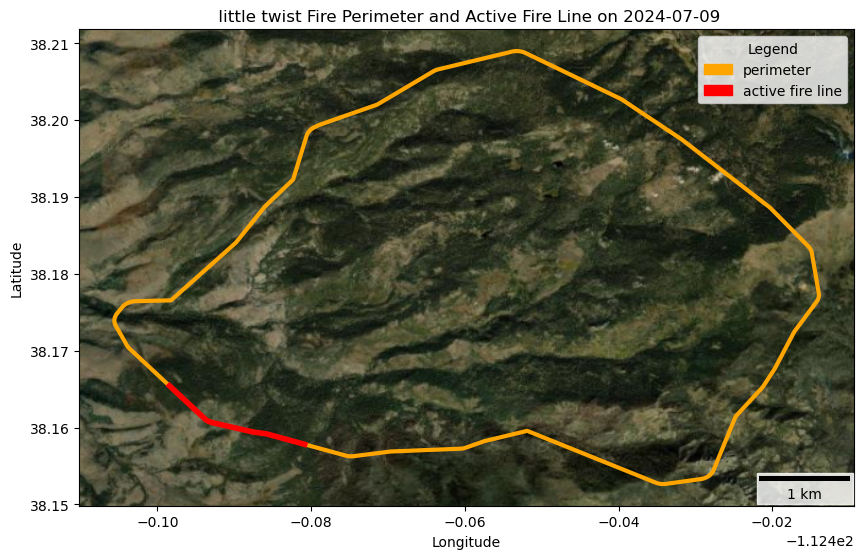

In [219]:
plot_snapshot(userPlace)

## Visualize the Growth of the Fire

We may be interested in understanding how a fire evolved through time. To do this, we can work with the "Large fire" or "lf" perimeter collections. Let's build a new function that utilizes this layer.

In [220]:
def plot_over_time(userPlace): 

    userPlace = str(userPlace)
    FuserPlace = "F" + userPlace

    perimeters_archive_results = w.collection_items(
        "public.eis_fire_lf_perimeter_nrt",
        filter=f"fireid = '{FuserPlace}'",
        limit=9999

    )

    perimeters_archive_results
    perimeters = gpd.GeoDataFrame.from_features(perimeters_archive_results["features"])
    perimeters = perimeters.set_crs("epsg:4326")
    #With the fire queried, we can manipulate the time column to make sure it plots in a more inteprettable way.

    import statistics
    import datetime
    from datetime import datetime
    min_time = str(perimeters.t.min()).split('T')[0]
    max_time = str(perimeters.t.max()).split('T')[0]

    print("Start Date:" + min_time)
    print("Most Recent Date:" + max_time)

    from matplotlib.pyplot import legend

    fig = perimeters.plot(column = 't', cmap = 'autumn_r', figsize=(10,12), linewidth=3, facecolor = 'none', legend = True)
    plot_title = (f"Growth of {FuserPlace} Fire from {min_time} to {max_time}")
    if NameOfFire:
        plot_title=(f" Growth of {NameOfFire} Fire from {min_time} to {max_time}")
    fig.set_title(plot_title)
    fig.set_xlabel("Longitude")
    fig.set_ylabel("Latitude")
    cx.add_basemap(fig, crs=perimeters.crs.to_string(), source=cx.providers.Esri.WorldImagery, attribution = False)
    red_patch = mpatches.Patch(color='red', label = max_time)
    yellow_patch = mpatches.Patch(color = 'yellow', label = min_time)
    matplotlib.pyplot.legend(handles = [yellow_patch,  red_patch], title='Date Range', bbox_to_anchor=(1.0,1.0))
    scale1 = ScaleBar(
        dx=distance_meters,
        location="lower right",  # in relation to the whole plot
        box_alpha=0.8,
    )
    fig.add_artist(scale1)
    return fig, perimeters 

Now run the function.

Start Date:2024-06-01
Most Recent Date:2024-07-23


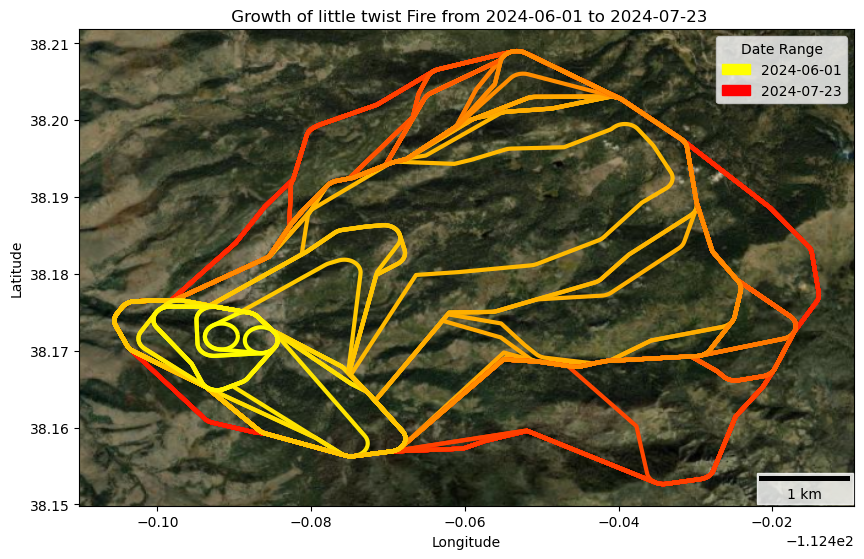

In [221]:
fig, perimeters = plot_over_time(userPlace)

### Now let's make a GIF of this growth over time!

We can start by cleaning up our perimeters df.

In [222]:
# Filter out rows with None or empty geometries
perimeters = perimeters[perimeters['geometry'].notna() & ~perimeters['geometry'].is_empty]
perimeters = perimeters[perimeters['flinelen'] > 0]

# Convert 't' column to datetime for easier handling
perimeters['t'] = pd.to_datetime(perimeters['t'])

# Sort the data by date
perimeters = perimeters.sort_values(by='t')

And here's a function to generate a frame of the fire at each time it was recorded, then combine the frames into a .mp4 video. 

In [223]:
def generate_gif(perimeters):

    import os
    # Initialize cumulative perimeter
    cumulative_perimeter = gpd.GeoDataFrame(geometry=[], crs=perimeters.crs)


    # Prepare intermediate data directory
    intermediate_dir = 'intermediate_clipped_data'
    if not os.path.exists(intermediate_dir):
        os.makedirs(intermediate_dir)

    # Preprocess each perimeter
    dates = perimeters['t'].unique()
    for i, date in enumerate(dates):
        # Filter for current date's data
        current_perimeters = perimeters[perimeters['t'] == date]

        # Clip current perimeters with cumulative perimeter
        if not cumulative_perimeter.empty:
            try:
                current_perimeters = gpd.overlay(current_perimeters, cumulative_perimeter, how='difference', keep_geom_type=False)
            except:
                from shapely.geometry import shape, mapping
                def around(geom,p):
                    geojson = mapping(geom)
                    geojson['coordinates'] = np.round(np.array(geojson['coordinates']),p)
                    return  shape(geojson)
                perimeters.geometry= perimeters.geometry.apply(lambda x: around(x,4))

        # Save the clipped current perimeters
        current_perimeters.to_file(os.path.join(intermediate_dir, f'clipped_perimeters_{i}.geojson'), driver='GeoJSON')

        # Update cumulative perimeter
        cumulative_perimeter = gpd.GeoDataFrame(pd.concat([cumulative_perimeter, current_perimeters], ignore_index=True))


    # Function to add black outline to text
    def draw_text_with_outline(ax, text, x, y, fontsize=14, fontweight='bold', fontcolor='white', outlinecolor='black'):
        from matplotlib.patheffects import withStroke
        ax.text(x, y, text, verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes, fontsize=fontsize, fontweight=fontweight, color=fontcolor,
                path_effects=[withStroke(linewidth=3, foreground=outlinecolor)])

    # Color interpolation function for creating a gradient of darker colors
    def generate_darker_colors(base_color, num_colors):
        base_rgb = np.array(mcolors.hex2color(base_color))
        colors = []
        for i in range(num_colors):
            factor = (i + 1) / num_colors
            darker_rgb = base_rgb * (1 - factor)
            colors.append(mcolors.to_hex(darker_rgb))
        return colors

    # Generate a list of darker colors for each time step
    base_color = '#f77f00'
    num_dates = len(perimeters['t'].unique())
    darker_colors = generate_darker_colors(base_color, num_dates)[::-1]

    # Prepare output directory for frames
    output_dir = 'frames_new'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define the style for the current growth layer
    growth_style = {
        'edgecolor': '#f94144',
        'facecolor': base_color,
        'alpha': 0.7,
        'linewidth': 2
    }

    # Calculate the overall bounding box with a buffer
    total_bounds = perimeters.total_bounds

    #### IMPORTANT: Adjust this buffer value as needed, to give extra breathing room around the edge of the map ####
    buffer = 0.1

    x_min, y_min, x_max, y_max = total_bounds[0] - buffer, total_bounds[1] - buffer, total_bounds[2] + buffer, total_bounds[3] + buffer

    # Create frames
    dates = perimeters['t'].unique()
    for i, date in enumerate(dates):
        fig, ax = plt.subplots(1, 1, figsize=(14, 14))  # Increase figure size for better visibility

        # Load preprocessed clipped perimeters for the current date
        current_perimeters = gpd.read_file(os.path.join(intermediate_dir, f'clipped_perimeters_{i}.geojson'))

        # Plot all previous perimeters with unique darker colors
        for j in range(i-1, -1, -1):  # Iterate in reverse order to plot oldest on top
            past_perimeters = gpd.read_file(os.path.join(intermediate_dir, f'clipped_perimeters_{j}.geojson'))
            past_color = darker_colors[j]
            past_style = {
                'edgecolor': past_color,
                'facecolor': past_color,
                'alpha': 0.7,
                'linewidth': 1
            }
            past_perimeters.plot(ax=ax, **past_style, aspect=1)

        # Plot the current growth layer
        current_perimeters.plot(ax=ax, **growth_style, aspect=1)

        # Set fixed extent to ensure basemap remains consistent
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Add OSM HOT basemap
        ctx.add_basemap(ax, crs=perimeters.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution="", zoom=12)

        # Remove axis borders and labels
        ax.set_aspect('equal')
        ax.axis('off')

        # Add formatted date label in the top right corner
        formatted_date = date.strftime('%B %d, %Y')
        draw_text_with_outline(ax, f"{formatted_date}", 0.95, 0.95)

        # Add an inset axis for the overview map
        inset_ax = inset_axes(ax, width="25%", height="25%", loc='lower left', borderpad=2)

        # Plot the overview map in the inset axis
        inset_x_min = total_bounds[0] - 5
        inset_y_min = total_bounds[1] - 5
        inset_x_max = total_bounds[2] + 5
        inset_y_max = total_bounds[3] + 5
        inset_ax.set_xlim(inset_x_min, inset_x_max)
        inset_ax.set_ylim(inset_y_min, inset_y_max)
        ctx.add_basemap(inset_ax, crs=perimeters.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution="", zoom = 4)
        inset_ax.set_aspect('equal')
        inset_ax.axis('off')

        # Draw a red box around the affected area
        inset_ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     edgecolor='red', facecolor='none', linewidth=2))

        # Add a border around the inset
        inset_border = Rectangle((0, 0), 1, 1, transform=inset_ax.transAxes,
                                 facecolor='none', edgecolor='black', linewidth=2, clip_on=False)
        inset_ax.add_patch(inset_border)

        # Save frame
        frame_path = os.path.join(output_dir, f'frame_{i:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

    print(f"Static images saved in directory: {output_dir}")

    # Prepare output MP4 file
    output_mp4 = 'fire_animation.mp4'

    # Collect all frame file paths
    frames = [os.path.join(output_dir, f'frame_{i:03d}.png') for i in range(len(dates))]

    # Create animated MP4
    with imageio.get_writer(output_mp4, mode='I', fps=1) as writer:  #Adjust FPS here
        for frame_path in frames:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    print(f"Animated MP4 saved as: {output_mp4}")
    

Now we can run the function. 

In [224]:
gif = generate_gif(perimeters)

Static images saved in directory: frames_new


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3255, 2860) to (3264, 2864) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x6b9d6c0] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x6bb6a40] Warning: data is not aligned! This can lead to a speed loss


Animated MP4 saved as: fire_animation.mp4


To access your GIF, download the fire_animation.mp4 that's populated in your directory. Name it as the fireid or fire name for organization purposes. You can then open the download. 

### Fire Weather 

Here we can look at how the weather during the fire compares to historical averages. To do this we'll plot FWI as well as the major variables that determine FWI (temperature, humidity, and wind speed).

NOTE: This is experimental. Not all fires have weather stations within a realtively close distance, so data may not be accurate to actual conditons during the fire. 

In [225]:
def plot_FWI_over_time(userPlace):

    files = fv.listFD("https://portal.nccs.nasa.gov/datashare/GlobalFWI/StnFWI/19900101.NRT/FWI", "csv") # This will update through time. Not nessisary now because focus on 2019
    st_id_map = pd.read_csv('https://portal.nccs.nasa.gov/datashare/GlobalFWI/StnFWI/19900101.NRT/isd-history.csv')

    stations = fv.st_avail(files, st_id_map)
    st_dict = stations[['Lat', 'Lon']].to_dict('records')

    ## Load up that fire 
    fireID = str(userPlace)
    gdf = fv.load_large_fire(fireID, year = "2024", path_region = "CONUS_NRT_DPS")

    foi = gdf
    foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
    foi = foi.iloc[0] # First element

    ## Look for closest station
    st_cls = fv.closest(st_dict, foi)
    st_cls

    ## Get station Data
    st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations, flag_bad=False)

    import datetime

    coords = st_cls
    # Create a list with latitude and longitude as numeric values
    coords = [coords['Lat'], coords['Lon']]

    vars = ['FWI', 'TEMP_C', 'RH_PERC', 'WDSPD_KPH']
    for var in vars: 
        fv.plot_st_history(st_id_map, st_dict, stations, lat_lon=coords,  plot_var = var)
        

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI


/projects/fwiVis/base-fwi-vis/fwiVis/fwiVis.py:596: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/fwiVis/base-fwi-vis/fwiVis/fwiVis.py:597: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


The closest station is 604.8504740145847 km away.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.


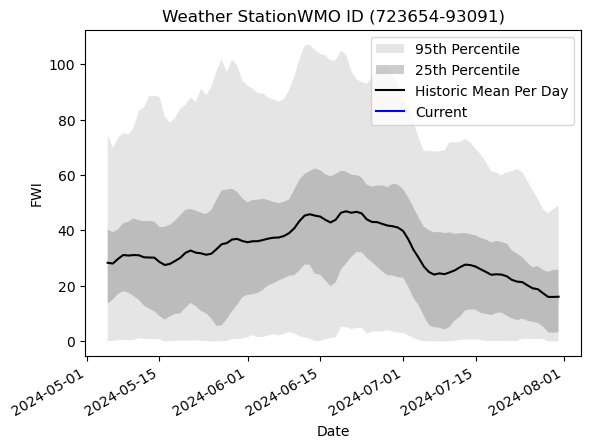

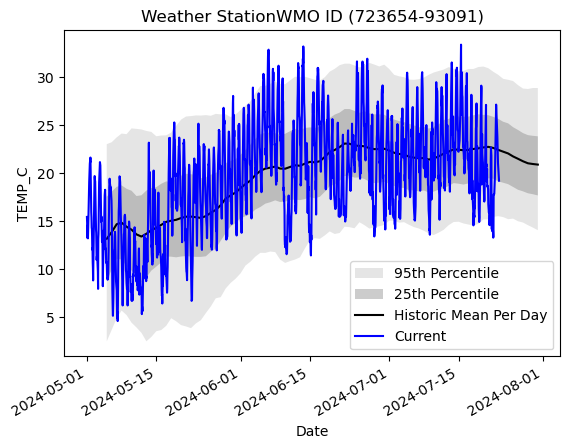

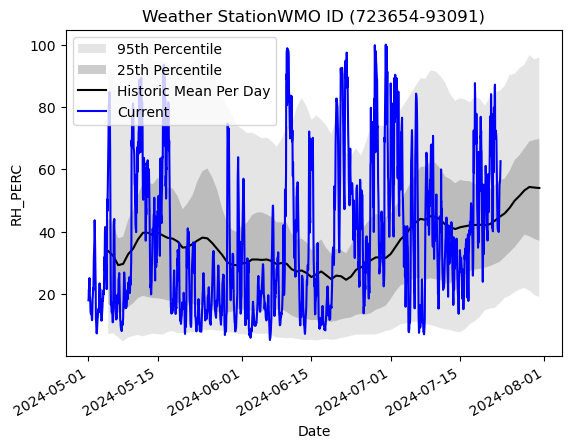

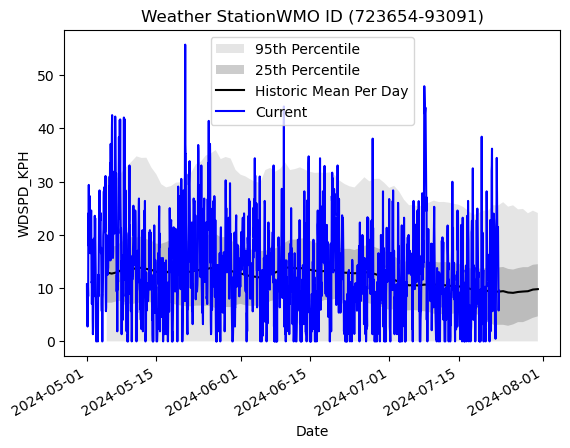

In [226]:
plot_FWI_over_time(userPlace)